In [1]:
#installation
!pip install datasets

In [2]:
#import
from datasets import load_dataset

#dataset loading
pr_request = load_dataset("hao-li/AIDev", name="pull_request", split="train")

#dataframe
df_pr_request= pr_request.to_pandas()

#prints
print("Columns of pull_request:")
print(df_pr_request.columns.tolist())

Columns of pull_request:
['id', 'number', 'title', 'body', 'agent', 'user_id', 'user', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url', 'html_url']


In [3]:
#dataset loading
all_pr_request = load_dataset("hao-li/AIDev", name="all_pull_request", split="train")

#dataframe
df_all_pr_request= all_pr_request.to_pandas()

#prints
print("Columns of all pull request:")
print(df_all_pr_request.columns.tolist())

Columns of all pull request:
['id', 'number', 'title', 'user', 'user_id', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_url', 'repo_id', 'html_url', 'body', 'agent']


In [4]:
#dataset loading
pr_commit_details = load_dataset("hao-li/AIDev", name="pr_commit_details", split="train")

#dataframe
df_pr_commit_details= pr_commit_details.to_pandas()

#prints
print("Columns of pr commit details:")
print(df_pr_commit_details.columns.tolist())

Columns of pr commit details:
['sha', 'pr_id', 'author', 'committer', 'message', 'commit_stats_total', 'commit_stats_additions', 'commit_stats_deletions', 'filename', 'status', 'additions', 'deletions', 'changes', 'patch']


In [5]:
#imports
import re
import pandas as pd

#Rename required tables for easier approach
pull_request = df_pr_request
commit_details = df_pr_commit_details

#Merge Tables
merged = commit_details.merge(
    pull_request,
    left_on="pr_id",
    right_on="id",
    how="inner",
    suffixes=("_commit", "_pr")
)
print(f"Merged dataset size: {len(merged)} rows")

#Test Type classification and patterns 
TYPE_PATTERNS = {
    "unit": [
        r"\bunit\b", r"\bunittest\b",
        r"(^|/|\\)test(s)?(/|\\|$)",
        r"test_.*\.py$", r"_test\.(js|ts|java|go|py)$"
    ],
    "integration": [
        r"\bintegration\b", r"\bintegrat(e|ion)_test\b",
        r"(^|/)integration(s)?/"
    ],
    "e2e": [
        r"\be2e\b", r"end[-_ ]?to[-_ ]?end",
        r"/e2e/", r"/cypress/"
    ],
    "performance": [r"\bperf\b", r"\bperformance\b"],
    "regression": [r"\bregression\b"],
    "smoke": [r"\bsmoke\b"],
    "benchmark": [r"\bbenchmark\b", r"\bbench\b"],
}

def classify_test(file_path, commit_msg):
    text = f"{file_path} {commit_msg}".lower()

    for ttype, patterns in TYPE_PATTERNS.items():
        for p in patterns:
            if re.search(p, text):
                return ttype

    if ("test" in text or "spec" in text):
        return "other"

    return "unknown"


merged["test_type"] = merged.apply(
    lambda row: classify_test(row.get("file_path", ""), row.get("message", "")),
    axis=1
)

#Tests Per PR statistics
merged["has_test_file"] = merged["test_type"].apply(lambda x: x != "unknown")

pr_stats = merged.groupby("pr_id").agg(
    total_commits=("sha", "count"),  
    total_test_files=("has_test_file", "sum"),
    test_types=("test_type", lambda x: list(x[x != "unknown"]))
).reset_index()

pr_stats["contains_tests"] = pr_stats["total_test_files"] > 0
print("Completed per PR test statistics")

#Percentage of tests
total_agentic = len(pr_stats)
agentic_with_tests = pr_stats["contains_tests"].sum()
pct_with_tests = 100 * agentic_with_tests / total_agentic

print("\n======================")
print("GLOBAL TEST STATISTICS")
print("======================")
print(f"Total Agentic PRs: {total_agentic}")
print(f"Agentic PRs containing tests: {agentic_with_tests}")
print(f"Percentage: {pct_with_tests:.2f}%\n")

test_type_counts = merged["test_type"].value_counts().reset_index()
test_type_counts.columns = ["test_type", "count"]

print("Test Type Distribution:")
print(test_type_counts)


Merged dataset size: 711923 rows
Completed per PR test statistics

GLOBAL TEST STATISTICS
Total Agentic PRs: 33580
Agentic PRs containing tests: 8372
Percentage: 24.93%

Test Type Distribution:
     test_type   count
0      unknown  589632
1        other   97331
2  integration   12041
3         unit    4349
4  performance    3164
5    benchmark    2366
6          e2e    2036
7   regression     905
8        smoke      99


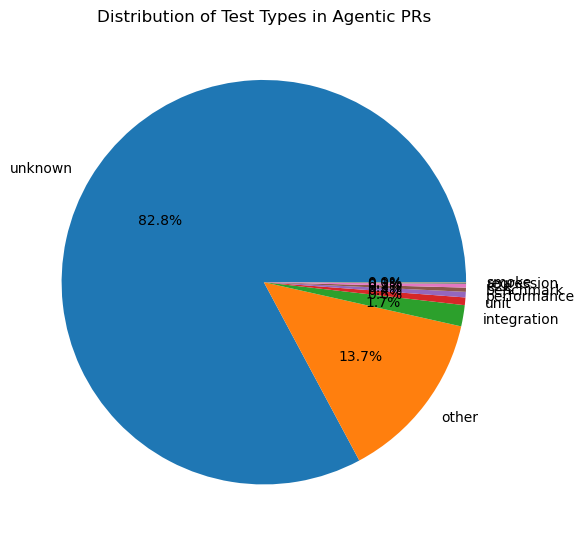

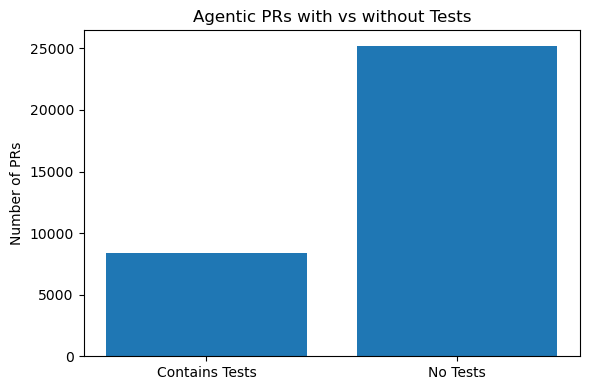

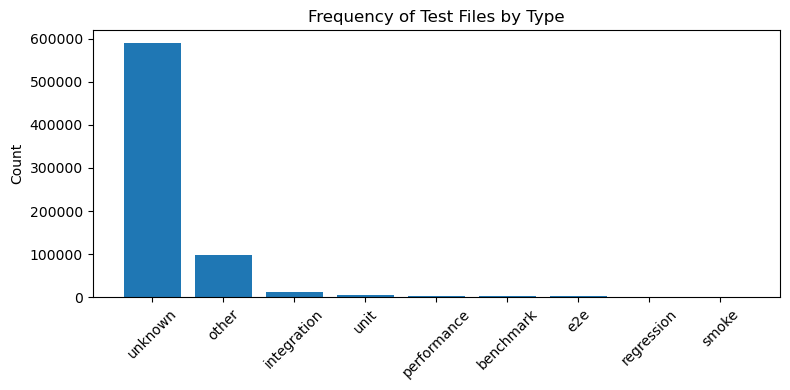

Completed


In [6]:
#imports
import matplotlib.pyplot as plt

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(test_type_counts["count"], labels=test_type_counts["test_type"], autopct="%1.1f%%")
plt.title("Distribution of Test Types in Agentic PRs")
plt.tight_layout()
plt.show()

# PRs with vs without tests
plt.figure(figsize=(6,4))
plt.bar(["Contains Tests", "No Tests"], [agentic_with_tests, total_agentic - agentic_with_tests])
plt.title("Agentic PRs with vs without Tests")
plt.ylabel("Number of PRs")
plt.tight_layout()
plt.show()

# Test file frequency
plt.figure(figsize=(8,4))
plt.bar(test_type_counts["test_type"], test_type_counts["count"])
plt.title("Frequency of Test Files by Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Completed")